In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

In [2]:
gen = ImageDataGenerator(rescale=1./255,validation_split = 0.2,zoom_range=(0.99,0.99),dtype=tf.float32)

In [3]:
train = gen.flow_from_directory("../ControlledDataSet/",
                               target_size = (150,150),
                               batch_size = 256,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "training")
                
val = gen.flow_from_directory("../ControlledDataSet/",
                               target_size = (150,150),
                               batch_size = 8,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "validation")
classes = val.class_indices

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [4]:
classes

{'BrainTumor': 0, 'Healthy': 1}

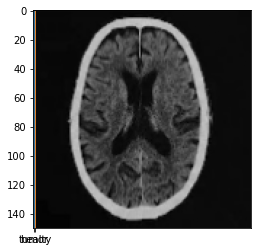

In [5]:
t=0
h=0
for i in range(15):
    a, b = next(train)
    for j in b:
        if j == 1:
            h+=1
        else:t+=1

sns.barplot(x=['tumor','healty'],y=[t,h])
import matplotlib.pyplot as plt
batch = next(train)

plt.imshow(batch[0][0])

In [6]:
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten, Input
from keras.losses import MeanSquaredError
from keras.optimizers import SGD
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from tensorflow.keras import layers

In [7]:
input_tensor = Input(shape=(100, 100, 3))  # this assumes K.image_data_format() == 'channels_last'

resnet_model = ResNet50(input_tensor=input_tensor,weights='imagenet', include_top=False)

for layer in resnet_model.layers:
    layer.trainable=False

resnet = Sequential()
resnet.add(resnet_model)
resnet.add(layers.Conv2D(32, kernel_size=(3,3), strides=(3,3), activation='relu', padding='same', input_shape=(100, 100, 1)))
resnet.add(layers.ReLU())
resnet.add(layers.MaxPooling2D(pool_size=(2,2)))
resnet.add(layers.Flatten())
resnet.add(layers.Dense(activation='relu', units=64))
resnet.add(layers.Dropout(0.2))
resnet.add(layers.Dense(activation='sigmoid', units=1))

resnet.compile(loss=MeanSquaredError(), optimizer=SGD(0.01), metrics=["accuracy"])

resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 32)          589856    
_________________________________________________________________
re_lu (ReLU)                 (None, 2, 2, 32)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [8]:
from keras import utils, callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

In [9]:
history = resnet.fit(train,verbose=1,callbacks = [earlystopping],epochs=20,validation_data=(val))

Epoch 1/20
2/2 [==============================] - 19s 10s/step - loss: 0.2693 - accuracy: 0.5417 - val_loss: 0.2327 - val_accuracy: 0.7250
Epoch 2/20
2/2 [==============================] - 17s 9s/step - loss: 0.2415 - accuracy: 0.5833 - val_loss: 0.2256 - val_accuracy: 0.7583
Epoch 3/20
2/2 [==============================] - 16s 8s/step - loss: 0.2312 - accuracy: 0.6271 - val_loss: 0.2275 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 14s 7s/step - loss: 0.2388 - accuracy: 0.5708 - val_loss: 0.2215 - val_accuracy: 0.5000
Epoch 5/20
2/2 [==============================] - 14s 7s/step - loss: 0.2324 - accuracy: 0.5667 - val_loss: 0.2092 - val_accuracy: 0.6583
Epoch 6/20
2/2 [==============================] - 13s 6s/step - loss: 0.2271 - accuracy: 0.6167 - val_loss: 0.2426 - val_accuracy: 0.5000
Epoch 7/20
2/2 [==============================] - 15s 7s/step - loss: 0.2758 - accuracy: 0.4667 - val_loss: 0.2280 - val_accuracy: 0.7000
Epoch 8/20
2/2 [=================

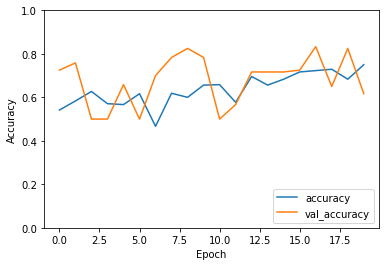

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


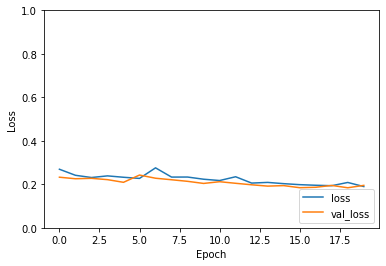

In [11]:

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [12]:
gen = ImageDataGenerator(rescale=1./255,zoom_range=(0.99,0.99),dtype=tf.float32)
test = gen.flow_from_directory("../temp/",
                               target_size = (150,150),
                               batch_size = 256,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "training")

classes = val.class_indices

Found 3906 images belonging to 2 classes.


In [13]:
_, acc  = resnet.evaluate(test, verbose=1)

16/16 [==============================] - 50s 3s/step - loss: 0.3065 - accuracy: 0.4882
